In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

In [3]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40262 instead
  http_address["port"], self.http_server.port


In [11]:
client

Client Scheduler: tcp://10.12.206.54:35525 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


In [12]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [13]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [14]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

### CTL2010

In [15]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [16]:
#choose your subset of variables
data_vars = ['GPP','NPP','NBP','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','FCEV','FGEV','COL_FIRE_CLOSS','QHR','ALTMAX',
             'TWS','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']
keys = paramkey.key
#read in the dataset
ds = get_ensemble('CTL2010',data_vars,'h0',keys,paramkey)

In [17]:
uniques = np.unique(ds.param)
ix = uniques=='default'
uniques = uniques[~ix]

In [27]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])
    

In [57]:
def top_n(da,nx,params,minmax,uniques):
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

In [89]:
cfs = dict()
units = dict()

#fluxes [summed, extensive variable]
for field in ['GPP','HR','AR','NPP','NBP','COL_FIRE_CLOSS']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'PgC/yr'
for field in ['FCTR','FCEV','FGEV','EFLX_LH_TOT']:
    cfs[field]   = 1/2.5e6*1e-9*24*60*60
    units[field] = 'TtH2O/yr'
for field in ['QHR','QVEGT']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'TtH2O/yr'
    
#FAREA [summed, extensive variable]
cfs['FAREA_BURNED']=24*60*60/1e6
units['FAREA_BURNED']='1e6km2'
    
#pools [averaged, extensive variable]
for field in ['TWS','SOILWATER_10CM']:
    cfs[field]   = 1e-9/365
    units[field] = 'TtH2O'
for field in ['TOTVEGC','TOTSOMC_1m']:
    cfs[field]   = 1e-9/365
    units[field] = 'PgC'
    
#intensives (need to account for landarea)
lasum = la.sum().values
for field in ['SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']:
    cfs[field]   = 1/la.sum()/365
    units[field] = ds[field].attrs['units']
    
#ALT
field='ALTMAX'
cfs[field]=1/lasum
units[field] = ds[field].attrs['units']

In [58]:
def calc_mean(ds,datavar):
    cf = cfs[datavar]
    x  = ds[datavar]
    
    da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_mean = da_ann.mean(dim='year') 
    
    return da_mean,da_ann

In [62]:
def calc_iav(ds,datavar,da_ann=[]):
    #compute da_ann if not provided
    if len(da_ann)==0:
        cf = cfs[datavar]
        x  = ds[datavar]
        da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_iav = da_ann.std(dim='year')
    return da_iav
        

In [71]:
def calc_alt(ds):
    cf   = cfs['ALTMAX']
    ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<10
    xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim='gridcell').compute()
    xm   = xann.mean(dim='year')
    xi   = xann.std(dim='year')
    return xm,xi

In [85]:
def plot20(datavar,xdef,xmins,xmaxs,pvals,op,unit):
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    plt.legend()
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(datavar+'_'+op)
    plt.xlabel(datavar+'_'+op+' ('+unit+')');

In [94]:
def twoplots(ds,datavar,xm,xi,uniques):
    plt.subplot(121)
    xdef  = xm.isel(ens=0)
    xmins,xmaxs,pm = top_n(xm,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pm,'mean',units[datavar])

    plt.subplot(122)
    xdef  = xi.isel(ens=0)
    xmins,xmaxs,pi = top_n(xi,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pi,'IAV',units[datavar])


    plt.subplots_adjust(wspace=0.8)
    plt.subplots_adjust(left=0.22) 

    ln =ds[datavar].attrs['long_name'].capitalize()
    if len(ln)<100:
        plt.figtext(0.562,0.95,ln,fontsize=12,ha='center')
    else:
        i = int(len(ln)/2)
        ln1 = ln[:i]
        ln2 = ln[i:]
        plt.figtext(0.562,0.98,ln1,fontsize=12,ha='center')
        plt.figtext(0.562,0.94,ln2,fontsize=12,ha='center')
        
    return pm,pi


In [ ]:
cts      = {u:0 for u in uniques}
ct_means = {u:0 for u in uniques}
ct_iavs  = {u:0 for u in uniques}

for datavar in data_vars:
    print(datavar)
    if datavar=='ALTMAX':
        xm,xi = calc_alt(ds)
    else:
        xm,xa = calc_mean(ds,datavar)
        xi    = calc_iav(0,0,xa)

    plt.figure(figsize=[8,8])
    pm,pi = twoplots(ds,datavar,xm,xi,uniques)
    #plt.savefig('../figs/'+datavar+'_top20.pdf')
    plt.close("all")
    
    for p in pm:
        cts[p]+=1
        ct_means[p]+=1

    for p in pi:
        cts[p]+=1
        ct_iavs[p]+=1


GPP
NPP
NBP
AR
HR
EFLX_LH_TOT
FCTR
FAREA_BURNED
TOTVEGC
TOTSOMC_1m
FCEV
FGEV
COL_FIRE_CLOSS
QHR
ALTMAX
TWS
SOILWATER_10CM
SNOWDP
TV
TSOI_10CM
TLAI
FSR
FSH


In [131]:
pcts=sorted(cts.items(), key=lambda item: item[1])
pvals=[];ct0=[];ct1=[]
for p,x in pcts:
    
    if x==0:
        pvals.append(p)
        ct0.append(ct_means[p])
        ct1.append(ct_iavs[p])
    else:
        pvals.insert(0,p)
        ct0.insert(0,ct_means[p])
        ct1.insert(0,ct_iavs[p])
    
ct_table = pd.DataFrame({'param':pvals,'mean':ct0,'iav':ct1})
ct_table.to_html(buf='top20_summary.html')

In [ ]:
## make a summary table
nx = 20
ctmeans = dict()
ctiavs  = dict()

for datavar in data_vars:
    print(datavar)
    cf      = cfs[datavar]

    xmeans,xiavs,xann = param_effect(ds,datavar,cf,uniques,da=[])

    topx,pvals = top_n(xmeans,uniques,nx)
    for p in pvals:
        if p not in ctmeans:
            ctmeans[p]=1
        else:
            ctmeans[p]=1+ctmeans[p]

    topx,pvals = top_n(xiavs,uniques,nx)
    for p in pvals:
        if p not in ctiavs:
            ctiavs[p]=1
        else:
            ctiavs[p]=1+ctiavs[p]



In [50]:
cts = ctmeans.copy()
for p in ctiavs:
    if p not in cts:
        cts[p]=ctiavs[p]
    else:
        cts[p]=cts[p]+ctiavs[p]

In [56]:
ctsort = np.flipud(sorted(cts.items(), key=lambda item: item[1]))

In [165]:
x=[]
len(x)

0

## coupling index

In [58]:
tape='h5'
data_vars = ['SOILWATER_10CM','FSH']
dsd = get_ensemble('CTL2010',data_vars,tape,keys,paramkey)

In [60]:
#skip the first timestep and reindex
t=np.arange(3651)
dsd = dsd.shift(time=-1).sel(time=t<3650)

In [63]:
x = ds.SOILWATER_10CM.groupby('time.season')
y = ds.FSH.groupby('time.season')
cv0 = (x-x.mean())*(y-y.mean())
cv  = cv0.groupby('time.season').sum()/x.count()
couplingIndex = (cv/x.std()).compute()

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


In [71]:
hot_area = (la*(couplingIndex<-10)).sum(dim='gridcell')
rel_area = hot_area/hot_area[0,:]

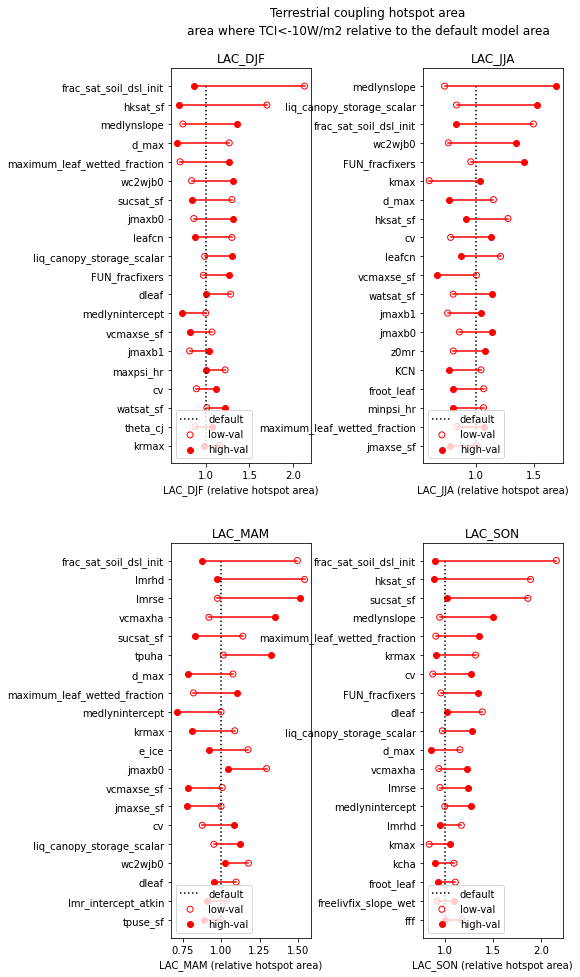

In [95]:
unit = 'relative hotspot area'
ln1  = 'Terrestrial coupling hotspot area'
ln2  = 'area where TCI<-10W/m2 relative to the default model area'
plt.figure(figsize=[8,16])
for i,seas in zip(range(4),rel_area.season):
    sstr = str(seas.values)
    xmeans  = []
    for u in uniques:
        pair  = find_pair(rel_area.sel(season=seas),ds.param,ds.minmax,u)
        xmeans.append(pair.values)

    dmeans = [abs(xmean[0]-xmean[1]) for xmean in xmeans]
    ranks = np.argsort(dmeans)
    xdef = rel_area.sel(season=seas).isel(ens=0)

    plt.subplot(2,2,i+1)
    plot20(xmeans,ranks,xdef,'LAC',sstr,unit)

plt.subplots_adjust(wspace=0.8)
plt.subplots_adjust(left=0.22) 
plt.figtext(0.562,0.925,ln1,fontsize=12,ha='center')
plt.figtext(0.562,0.91, ln2,fontsize=12,ha='center')
plt.savefig('../figs/LAcoupling_top20.pdf')

## C285

In [139]:
ds2 = get_ensemble('C285',data_vars,'h0',keys,paramkey)

In [140]:
datavar = 'GPP'
xm_ctl,xa = calc_mean(ds,datavar)
xm_285,xa = calc_mean(ds2,datavar)

In [182]:
dxs   =[]
ferts =[]
for u in uniques:
    pair1 = find_pair(xm_ctl,ds.param,ds.minmax,u).values
    pair2 = find_pair(xm_285,ds.param,ds.minmax,u).values
    
    co2fert_lo = pair1[0]/pair2[0]
    co2fert_hi = pair1[1]/pair2[1]
    
    dx = abs(co2fert_hi-co2fert_lo)
    
    ferts.append([co2fert_lo,co2fert_hi])
    dxs.append(dx)

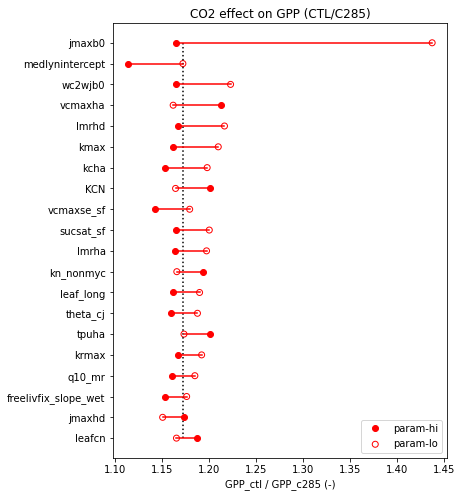

In [209]:
ranks = np.argsort(dxs)
pvals = [uniques[ranks[i]] for i in range(-20,0,1)]
xmins = [ferts[ranks[i]][0] for i in range(-20,0,1)]
xmaxs = [ferts[ranks[i]][1] for i in range(-20,0,1)]

plt.figure(figsize=[6,8])
fert_def = xm_ctl.isel(ens=0)/xm_285.isel(ens=0)
plt.plot([fert_def,fert_def],[-1,-20],'k:')
plt.scatter(xmins,range(-20,0,1),marker='o',facecolors='none', edgecolors='r',label='param-lo')
plt.plot(xmaxs,range(-20,0,1),'ro',label='param-hi')
plt.legend()
for i in range(-20,0,1):
    ix = ranks[i]
    fert = ferts[ix]
    plt.plot(fert,[i,i],'-r')

plt.yticks(range(-20,0,1),pvals);
plt.xlabel('GPP_ctl / GPP_c285 (-)')
plt.title('CO2 effect on GPP (CTL/C285)');


### notes
 - run the sand_pf, clay_pf
 - add pools to metric list
 
 
 - normalize by IAV for env ctrls
 - normalize by IAV for ctrl?
 
 
 - ecoregion?
 - seasonal cycle?
 
 - make a pdf summarizing the parameter effects

In [ ]:
((gpp_medhi_ctl - gpp_medhi_c285) - (gpp_medlo_ctl - gpp_mdlo_c285)) / IAV_ctl

## deprecated (for now)

In [ ]:
def param_effect(pair):
    delt  = pair.isel(ens=0)-pair.isel(ens=1)
    sigma = np.std(delt.mean(dim='year'))
    if sigma>0:
        pe_mean = abs((la*delt).sum(dim='gridcell').mean(dim='year').values)
        iav     = (la*pair).sum(dim='gridcell').std(dim='year').values
        pe_iav  = abs(iav[0]-iav[1])
    else:
        pe_mean = 0
        pe_iav  = 0

    
    return pe_mean,pe_iav
def spatial(da,params,uniques):
    #lower scores have more distinct spatial signature
    nx = len(uniques)
    
    #calculate delta annual mean for each param-pair
    delts = np.ndarray([nx,400])
    for i,u in zip(range(nx),uniques):
        pair = find_pair(da,params,u).mean(dim='year')
        delt = pair.isel(ens=0) - pair.isel(ens=1)
        delts[i,:] = delt
        
    #calculate cross-correlations
    #  skip calc if sigma==0
    sigs = np.std(delts,axis=1)
    rvals = np.zeros([nx,nx])
    for i in range(nx):
        if sigs[i]==0:
            rvals[i,:]=1
        else:
            for j in range(i,nx,1):
                if sigs[j]==0:
                    rvals[i,j] = 1
                elif i==j:
                    rvals[i,j] = 1
                else:
                    x=delts[[i,j],:]
                    r2= np.corrcoef(x)[0,1]**2
                    rvals[i,j] =r2
                    rvals[j,i] =r2
                    
    return rvals.sum(axis=0)

In [258]:
#choose your subset of variables
data_vars = ['GPP','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TWS','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR']
keys = paramkey.key
#read in the dataset
c285 = get_ensemble('C285',data_vars,'h0',keys,paramkey)

In [263]:
datavar = 'GPP'
s4 = []
da1 = (month_wts(10)*c285[datavar]).groupby('time.year').sum().compute()
da2 = (month_wts(10)*ds[datavar]).groupby('time.year').sum().compute()

In [277]:
s4=[]
for u in uniques:

    pair1 = find_pair(da1,ds.param,u)
    pair2 = find_pair(da2,ds.param,u)

    x1=(la*pair1).sum(dim='gridcell').mean(dim='year')
    x2=(la*pair2).sum(dim='gridcell').mean(dim='year')
    fx = (x1/x2).values
    dx = abs(fx[1]-fx[0])

    s4.append(dx)

In [280]:
ranks = np.argsort(s4)
for i in ranks[-5:]:
    u = uniques[i]
    print(u)

lmrhd
vcmaxha
wc2wjb0
medlynintercept
jmaxb0
